In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext.vocab as vocab
from torchtext.data import get_tokenizer
from torchtext.datasets import SST2
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import OpenAttack as oa
from IPython.core.display import display, HTML
%run models/Linear.ipynb
%run models/RNN.ipynb
%run models/SelfAttention.ipynb

C:\Users\sebas\AppData\Local\Temp\ipykernel_19412\2454200913.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iter = SST2(split="train")
val_iter = SST2(split="dev")
# test_iter = SST2(split="test")

tokenizer = get_tokenizer('spacy')

def yield_tokens_adv(data_iter):
    for text, _ in data_iter:
        yield tokenizer(text)

C:\Users\sebas\anaconda3\envs\mlGraphDATA\lib\site-packages\torchtext\data\utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [3]:
vocabulary = build_vocab_from_iterator(yield_tokens_adv(train_iter), specials=["<unk>"])
vocabulary.set_default_index(vocabulary["<unk>"])
glove_vectors = vocab.GloVe(name='6B', dim=100)
vocabulary.vectors = glove_vectors.get_vecs_by_tokens(vocabulary.get_itos())
BATCH_SIZE = 128
MAX_VOCAB_SIZE = 400000

In [4]:
import datasets


def dataset_mapping(x):
    return {
        "x": x["sentence"],
        "y": 1 if x["label"] > 0.5 else 0,
    }


# configure access interface of the customized victim model by extending OpenAttack.Classifier.
class MyClassifier(oa.Classifier):
    def __init__(self, model, fc=False):
        self.model = model
        self.fc = fc
    def get_pred(self, input_):
        return self.get_prob(input_).argmax(axis=1)

    # access to the classification probability scores with respect input sentences
    def get_prob(self, input_):
        ret = []
        for sent in input_:
            seq = []
            for word in tokenizer(sent):
                seq.append(vocabulary[word])
            v = torch.tensor(seq).view(1, -1)
            v = v.to(device)
            if self.fc:
                res = self.model.forward(v)
            else:
                res, _  = self.model.forward(v)
            res = F.softmax(res)
            res = {"pos": res[0, 0].cpu().detach().numpy(), "neg": res[0, 1].cpu().detach().numpy()}
            # we use 𝑠𝑜𝑐𝑟𝑒_𝑝𝑜𝑠 / (𝑠𝑐𝑜𝑟𝑒_𝑛𝑒𝑔 + 𝑠𝑐𝑜𝑟𝑒_𝑝𝑜𝑠) to represent the probability of positive sentiment
            # Adding 10^−6 is a trick to avoid dividing by zero.
            prob = (res["pos"] + 1e-6) / (res["neg"] + res["pos"] + 2e-6)

            ret.append(np.array([1 - prob, prob]))

        # The get_prob method finally returns a np.ndarray of shape (len(input_), 2). See Classifier for detail.
        return np.array(ret)


dataset = datasets.load_dataset("sst2", split="test[:50]", ).map(function=dataset_mapping)
attacker = oa.attackers.hotflip.HotFlipAttacker()

Found cached dataset sst2 (C:/Users/sebas/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)
Loading cached processed dataset at C:\Users\sebas\.cache\huggingface\datasets\sst2\default\2.0.0\9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5\cache-2c350f5a2a63fa68.arrow
C:\Users\sebas\anaconda3\envs\mlGraphDATA\lib\site-packages\nltk\corpus\reader\wordnet.py:1183: UserWarning: The multilingual functions are not available with this Wordnet version
  warnings.warn(


### Metrics

In [5]:
class PerturbationPosition(oa.AttackMetric):
    NAME = "PerturbationPosition"
    def __init__(self):
        self.counts = []
    def after_attack(self, sample, adversarial_sample):
        # print(sample, adversarial_sample)
        if adversarial_sample is None:
            return -1
        sample = tokenizer(sample["sentence"])
        adversarial_sample = tokenizer(adversarial_sample)
        for i, (sentence, sentence_adv) in enumerate(zip(sample, adversarial_sample)):
            for j , (word1, word2) in enumerate(zip(sentence, sentence_adv)):
                if word1 != word2:
                    self.counts.append(j / len(sentence))

In [6]:
class PerturbationAttention(oa.AttackMetric):
    NAME = "PerturbationAttention"
    def __init__(self, model):
        self.model = model
        self.sample = {'words': [], 'attention': []}
        self.adversarial_sample = {'words': [], 'attention': []}
        self.word_counts = []
    def after_attack(self, sample, adversarial_sample):
        # print(sample, adversarial_sample)
        if adversarial_sample is None:
            return -1
        seq = []
        seq_adv = []
        sample = tokenizer(sample["sentence"])
        adversarial_sample = tokenizer(adversarial_sample)
        self.sample['words'].append(sample)
        print(sample)
        self.adversarial_sample['words'].append(adversarial_sample)
        cnt = 0
        for i, (word1, word2) in enumerate(zip(sample, adversarial_sample)):
            seq.append(vocabulary[word1])
            seq_adv.append(vocabulary[word2])
            cnt+=1
        self.word_counts.append(cnt)
        seq = torch.tensor(seq).view(1, -1).to(device)
        seq_adv = torch.tensor(seq_adv).view(1, -1).to(device)
        self.sample['attention'].append(self.model.forward(seq)[1])
        self.adversarial_sample['attention'].append(self.model.forward(seq_adv)[1])


### Fully Connected Attack

In [7]:
net = FC(vocabulary)
net.load_state_dict(torch.load('FC_model.pt'))
net.to(device)
net.eval()
pp = PerturbationPosition()
victim = MyClassifier(net, True)# prepare for attacking
attack_eval = oa.AttackEval(attacker, victim, metrics=[
    pp
])
# launch attacks and print attack results
attack_fc = attack_eval.eval(dataset, visualize=False)
attack_fc

FileNotFoundError: [Errno 2] No such file or directory: 'FC_model.pt'

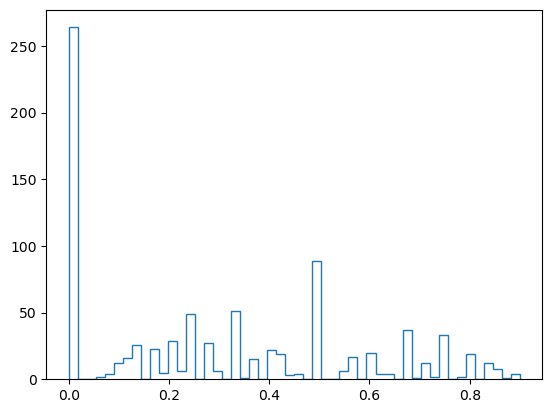

In [41]:
counts = np.array(pp.counts)
counts = counts[counts>=0]
c, b = np.histogram(pp.counts, bins=50)
plt.stairs(c, b)
plt.show()

### RNN Attack

In [ ]:
net = RNN(vocabulary)
net.load_state_dict(torch.load('rnn.pt'))
net.to(device)
net.eval()
pp = PerturbationPosition()
victim = MyClassifier(net, False)
# prepare for attacking
attack_eval = oa.AttackEval(attacker, victim, metrics=[
    pp
])
# launch attacks and print attack results
attack_rnn = attack_eval.eval(dataset, visualize=False)
attack_rnn

In [ ]:
counts = np.array(pp.counts)
counts = counts[counts>=0]
c, b = np.histogram(pp.counts, bins=50)
plt.stairs(c, b)
plt.show()

### Self-Attention Attack


In [8]:
net = AttentionModel(vocabulary)
net.load_state_dict(torch.load('models/attention.pt'))
net.to(device)
net.eval()
pp = PerturbationPosition()
pa = PerturbationAttention(net)
victim = MyClassifier(net, fc=False)
# prepare for attacking
attack_eval = oa.AttackEval(attacker, victim, metrics=[
    pp, pa
])
# launch attacks and print attack results
attack_att = attack_eval.eval(dataset, visualize=False)
attack_att

C:\Users\sebas\AppData\Local\Temp\ipykernel_19412\3204285435.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  res = F.softmax(res)


['uneasy', 'mishmash', 'of', 'styles', 'and', 'genres', '.']
['this', 'film', "'s", 'relationship', 'to', 'actual', 'tension', 'is', 'the', 'same', 'as', 'what', 'christmas', '-', 'tree', 'flocking', 'in', 'a', 'spray', 'can', 'is', 'to', 'actual', 'snow', ':', 'a', 'poor', '--', 'if', 'durable', '--', 'imitation', '.']
['by', 'the', 'end', 'of', 'no', 'such', 'thing', 'the', 'audience', ',', 'like', 'beatrice', ',', 'has', 'a', 'watchful', 'affection', 'for', 'the', 'monster', '.']
['director', 'rob', 'marshall', 'went', 'out', 'gunning', 'to', 'make', 'a', 'great', 'one', '.']
['lathan', 'and', 'diggs', 'have', 'considerable', 'personal', 'charm', ',', 'and', 'their', 'screen', 'rapport', 'makes', 'the', 'old', 'story', 'seem', 'new', '.']
['none', 'of', 'this', 'violates', 'the', 'letter', 'of', 'behan', "'s", 'book', ',', 'but', 'missing', 'is', 'its', 'spirit', ',', 'its', 'ribald', ',', 'full', '-', 'throated', 'humor', '.']
['although', 'it', 'bangs', 'a', 'very', 'cliched', 'dr

{'Total Attacked Instances': 50,
 'Successful Instances': 36,
 'Attack Success Rate': 0.72,
 'Avg. Running Time': 0.006243090629577636,
 'Total Query Exceeded': 0.0,
 'Avg. Victim Model Queries': 38.42,
 'Avg. PerturbationPosition': -1.0,
 'Avg. PerturbationAttention': -1.0}

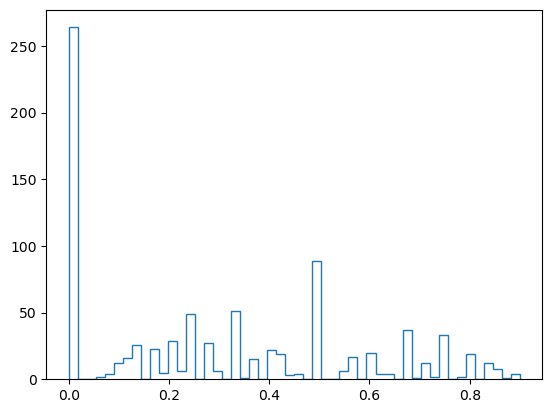

In [9]:
counts = np.array(pp.counts)
counts = counts[counts>=0]
c, b = np.histogram(pp.counts, bins=50)
plt.stairs(c, b)
plt.show()

694
['restless', 'mishmash', 'of', 'styles', 'and', 'genres', '.', 'this', 'celluloid', "'", 's', 'relationship', 'to', 'actual', 'tension', 'is', 'the', 'same', 'as', 'what', 'christmas', '-', 'tree', 'flocking', 'in', 'a', 'spray', 'can', 'is', 'to', 'actual', 'snow', ':', 'a', 'poor', '--', 'if', 'durable', '--', 'imitation', '.', 'by', 'the', 'terminal', 'of', 'no', 'such', 'thing', 'the', 'audience', ',', 'like', 'beatrice', ',', 'has', 'a', 'watchful', 'affection', 'for', 'the', 'monster', '.', 'manager', 'rob', 'marshall', 'went', 'out', 'gunning', 'to', 'make', 'a', 'great', 'one', '.', 'lathan', 'and', 'diggs', 'have', 'considerable', 'personal', 'good', ',', 'and', 'their', 'screen', 'resonance', 'makes', 'the', 'old', 'story', 'seem', 'new', '.', 'none', 'of', 'this', 'plunder', 'the', 'varsity', 'of', 'behan', "'", 's', 'record', ',', 'but', 'missing', 'is', 'its', 'spirit', ',', 'its', 'ribald', ',', 'full', '-', 'throated', 'humor', '.', 'although', 'it', 'spang', 'a', 'r

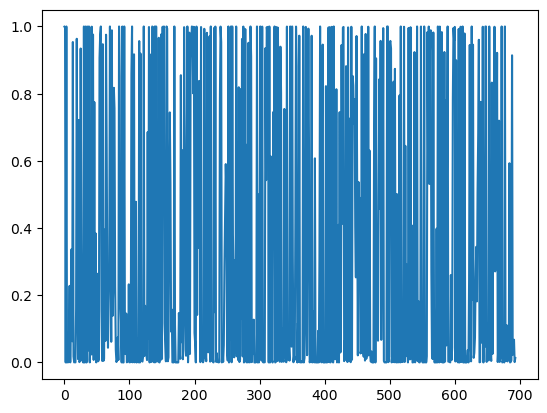

In [19]:
def concatenateMaps(map_tensor, adversial_map_tensor, num_sentences):
    attention_map = []
    adv_attention_map = []
    for i in range(num_sentences):
        att,_ = torch.max(map_tensor[i].squeeze(0), dim=0)
        adv_att,_ = torch.max(adversial_map_tensor[i].squeeze(0), dim=0)
        #att = torch.mean(pa.sample['attention'][i].squeeze(0), dim=0)

        attention_map.append(att.cpu().detach().numpy())
        adv_attention_map.append(adv_att.cpu().detach().numpy())
    return attention_map, adv_attention_map

allWords = sum(pa.sample['words'], [])
allWords_adv = sum(pa.adversarial_sample['words'], [])
print(len(allWords))
print(allWords_adv)
attention_map, adv_attention_map = concatenateMaps(pa.sample['attention'], pa.adversarial_sample['attention'], len(pa.sample['words']))
plt.plot(np.concatenate(attention_map))
plt.show()

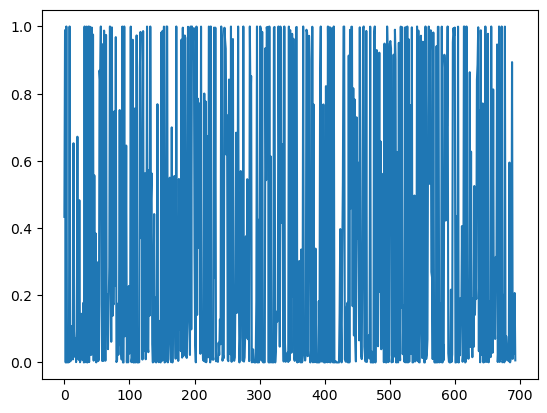

In [20]:
plt.plot(np.concatenate(adv_attention_map))
plt.show()

In [56]:
#generate for all sentences in the batch
def generateHeatedText(words, attention_map):
    text = []
    for i in range(len(words)):
        word = '<span style="background-color:rgba(255, 99, 71,'+ str(attention_map[i]) + ')">' +words[i]+ '</span>'
        text.append(word)
    text = ' '.join(text)

    display(HTML(text))
generateHeatedText(allWords, np.concatenate(attention_map))

In [57]:
generateHeatedText(pa.sample['words'][1], attention_map[1])

In [60]:
generateHeatedText(pa.adversarial_sample['words'][0], adv_attention_map[0])